<a target="_blank" href="https://colab.research.google.com/github/justramle/Emotion-Recognition-with-Convolutional-Neural-network/blob/main/emotion_classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Note:
To run this dataset onn colab: 
- Upload a zip file (images.zip) of a folder directly on the Colab notebook
- !unzip images.zip

# Train a deep learning model with Four‐layer ConvNet and Two-NN on facial emotion recognition with pytorch

### Dataset: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

- Consist of 48x48 pixels gray scales images of faces belong to 7 class
- size: 36k images
- 80% of images are insided the train folder and 20% are insided the validation folder

## References:

- https://cs231n.github.io/convolutional-networks/
- Paper 1: <br>
https://arxiv.org/pdf/1704.06756.pdf
- Source Code of CNN architect with tensorflow 1: <br>
https://github.com/rishabhjainps/Facial-Expression-Recognition/blob/master/cnn_major.py

- Paper 2: <br>
https://www.nature.com/articles/s41598-022-11173-0
- Source Code of CNN architect with tensorflow 2: <br>
https://github.com/Tanoy004/Emotion-recognition-through-CNN/blob/main/emotion_recognition.py


## Loading, processing and exploring the dataset

### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from plotly.subplots import make_subplots
import seaborn as sns
import os
import cv2

In [2]:
train_data_dir = 'images/train/'
validation_data_dir = 'images/validation/'

In [3]:
# debug
print(os.listdir(train_data_dir))
# print(os.listdir(os.path.join(train_data_dir,'happy')))

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


### Read all images in array and normalize in range [0,1] --> help optimizing the performance

In [4]:

# Function to load the image
def load_image(directory):
    images_path = []
    labels = []
    # access into each label folder and image inside that label
    for images_class in os.listdir(directory):
        for image_file in os.listdir(os.path.join(directory, images_class)):
            image_path = os.path.join(directory, images_class, image_file)
            # use openCV to open and read the image in grayscale: convert image into 2D Numpy Array: 
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)    
            # normalize pixel values between 0 and 1 to make the scale of the data consistent because the image scale is from 0-255 (very large)
            norm_image = image / 255.0
            # converting the pixel type to float 32 to reduce memory usage and data type consistent rather than default float 64
            norm_image = norm_image.astype('float32')
            images_path.append(norm_image)
            labels.append(images_class)
    return images_path, labels


### exploring with dataframe: easier to read

In [5]:
# load the images and labels from training set and inspect with dataframe to check the image tensor and lable
train = pd.DataFrame()
train['image'], train['label'] = load_image(train_data_dir)      # call the load_image function on train folder
# shuffle the dataset
# train = train.sample(frac=1).reset_index(drop=True)
train

,image,label
0,"[[0.7176471, 0.72156864, 0.7176471, 0.70980394...",happy
1,"[[0.9490196, 0.99215686, 0.99607843, 0.9960784...",happy
2,"[[0.4509804, 0.49411765, 0.47843137, 0.4705882...",happy
3,"[[0.6431373, 0.6862745, 0.69411767, 0.6901961,...",happy
4,"[[0.99215686, 0.99607843, 0.9411765, 0.9215686...",happy
...,...,...
28816,"[[0.99607843, 1.0, 0.99215686, 0.99607843, 0.7...",disgust
28817,"[[0.99607843, 1.0, 0.99215686, 0.99607843, 0.7...",disgust
28818,"[[0.15686275, 0.16470589, 0.14117648, 0.141176...",disgust
28819,"[[1.0, 0.9529412, 0.9019608, 0.7176471, 0.4588...",disgust


In [6]:
# # test set: use for validation purpose
# test = pd.DataFrame()
# test['image'], test['label'] = load_image(validation_data_dir)   
# test

### Doing the same but using numpy array: easier to use for ML/DL task than dataframe type

In [7]:
# convert lists into numpy (doing the same task as DF)
train_images, train_labels = load_image(train_data_dir)
test_images, test_labels = load_image(validation_data_dir)   

train_images = np.array(train_images)
# print(train_images)
train_labels = np.array(train_labels)
# print(train_labels)
test_images = np.array(test_images)
# print(test_images)
test_labels = np.array(test_labels)
# print(test_labels)

# verify shape of the dataset in numpy format: 48x48 pixels
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (28821, 48, 48)
Train labels shape: (28821,)
Test images shape: (7066, 48, 48)
Test labels shape: (7066,)


### Plotting sample image

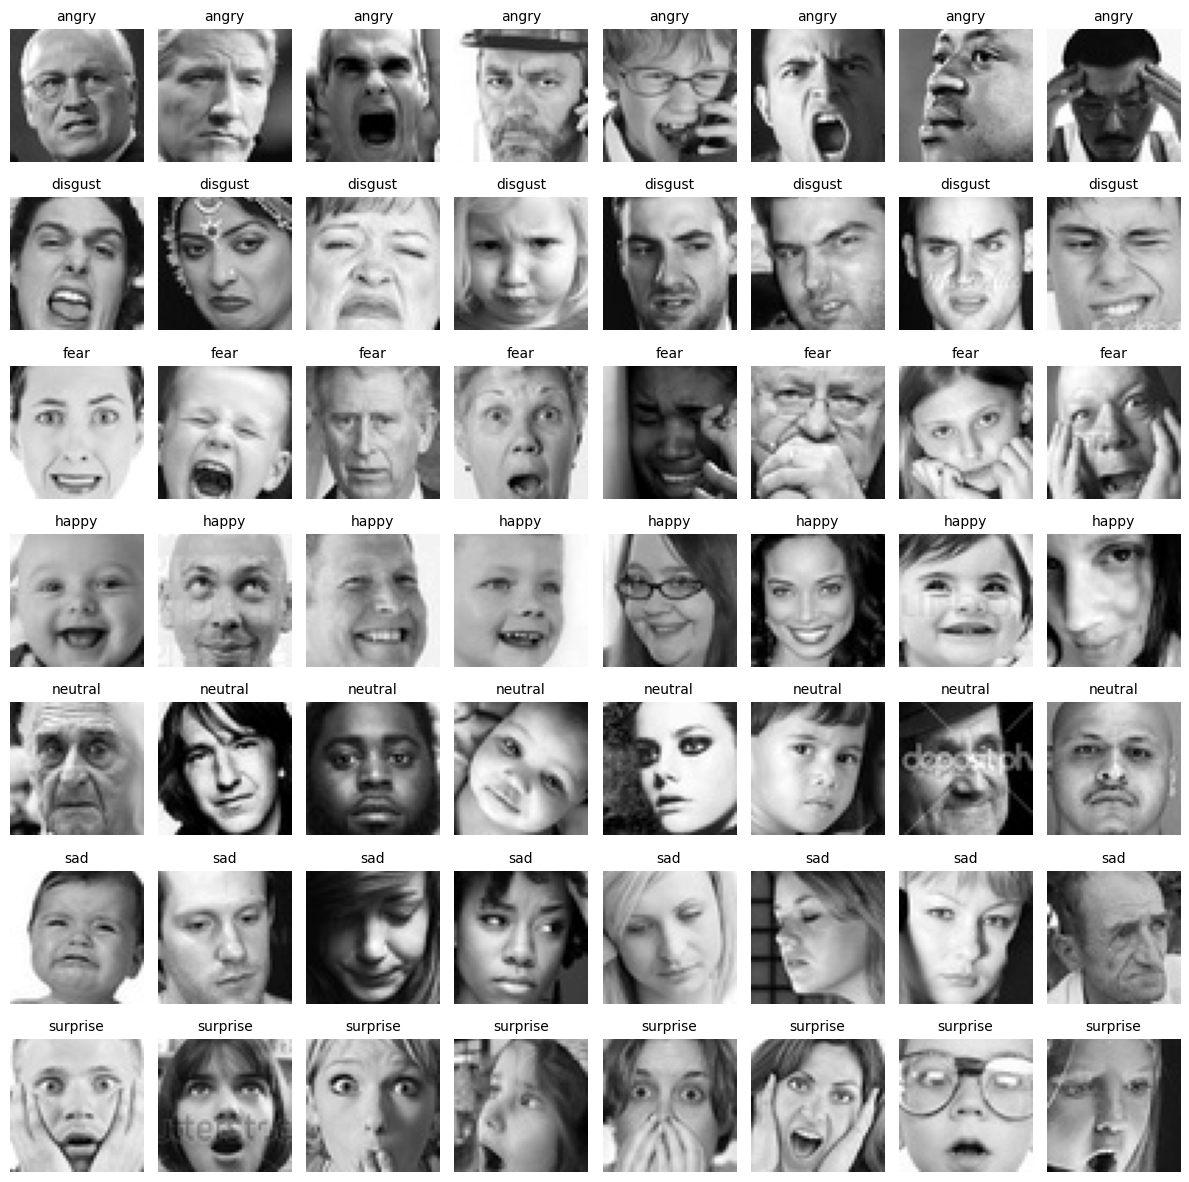

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(images, labels, num_samples):
    # Get unique labels and initialize the plot counter
    class_names = np.unique(labels)
    plot_count = 1
    
    # Determine the total number of plot rows needed
    num_classes = len(class_names)
    fig = plt.figure(figsize=(12, 12))
    
    for class_name in class_names:
        # Find indices of images belonging to the current class
        class_indices = np.where(labels == class_name)[0][:num_samples]
        for idx in class_indices:
            # Create a subplot for each sample image
            ax = fig.add_subplot(num_classes, num_samples, plot_count)
            ax.imshow(images[idx], cmap='gray')
            ax.axis('off')  # Hide axes ticks
            ax.set_title(class_name, fontsize=10)
            plot_count += 1

    plt.tight_layout()
    plt.show()

# function call
plot_sample_images(train_images, train_labels, num_samples=8)


### Plotting the training set distribution

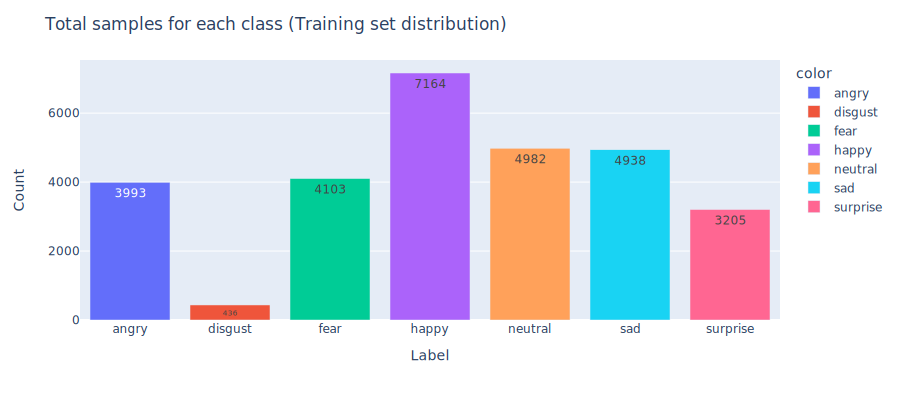

In [9]:
import plotly.express as px
import plotly.io as pio

# comment the renderers if using on colab
pio.renderers

# Calculate the count of images for each class in the training set
train_class_counts = {class_name: np.sum(train_labels == class_name) for class_name in np.unique(train_labels)}

# bar chart using Plotly Express for training set only
fig = px.bar(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), color=list(train_class_counts.keys()))

# Customize the layout of the chart
fig.update_layout(
    title="Total samples for each class (Training set distribution)",
    xaxis_title="Label",
    yaxis_title="Count",
    width=900,
    height=400
)
fig.update_traces(texttemplate='%{y}', textposition='inside')  # Display count labels on the bars
fig.show(renderer="svg")

## Bulding Deep Learning model with 4-layer of convolutional neural network and 2 fully connected layer

### import pytorch library and modules

In [10]:
import torch
# import torch.nn as Linear, Conv2d, MaxPool2d, BatchNorm2d, Dropout2d,  
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from torch.optim import Adam
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, BatchNorm2d, BatchNorm1d, Dropout
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder


### Prepare data before create CNN model
- convert data that was in numpy into pytorch tensor 
- convert label encoding which is currenly string
- shuffle training input to avoid overfitting with mini batch size 128
- recall varible: train_images/train_labels and test_images/test_labels in numpy above
    - Train set: 28821 images with the size 48x48 with 1 channel
    - Test set: 7066
 <br>
- Tensor with 3D structure with 1D for labels
    - First Dimension: Channel Depth
    - Second Dimension: Height
    - Third Dimension: Width

In [11]:
#-----TRAINING---- 
# converting train_images numpy into tensor 
train_x = train_images.reshape(28821, 1, 48, 48)        # could use reshape() or torch.unsqueeze() to add channel dim
train_x = torch.from_numpy(train_x)                     # could use torch.tensor() implicitly

# encoding labels  [0-6] and convert into tensor
train_label = LabelEncoder()
train_y = train_label.fit_transform(train_labels)
train_y = torch.from_numpy(train_y)
print(f'Training set first sample in Tensor format: \n {train_x[0]}')
print(f'\nLabels encoding for frist sample in Tensor format: \n {train_y}\n')
print(train_x.shape, train_y.shape, train_x.dtype)

# shuffle
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  


#-----VALIDATION---- 
# converting test_images into tensor 
val_x = test_images.reshape(7066, 1, 48, 48)            
val_x = torch.from_numpy(val_x)                         

# encoding test_labels 
test_label = LabelEncoder()
val_y = test_label.fit_transform(test_labels)
val_y = torch.from_numpy(val_y)

print(val_x.shape, val_y.shape, val_x.dtype)

# # no shuffle
val_dataset = TensorDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

Training set first sample in Tensor format: 
 tensor([[[0.7176, 0.7216, 0.7176,  ..., 0.3961, 0.3922, 0.3765],
         [0.7255, 0.7176, 0.7294,  ..., 0.3882, 0.3922, 0.3882],
         [0.7412, 0.7255, 0.7333,  ..., 0.3765, 0.3843, 0.3922],
         ...,
         [0.2000, 0.2118, 0.1804,  ..., 0.1647, 0.1765, 0.1451],
         [0.2196, 0.2157, 0.1294,  ..., 0.1961, 0.1804, 0.0706],
         [0.2118, 0.1843, 0.1490,  ..., 0.1922, 0.1843, 0.1529]]])

Labels encoding for frist sample in Tensor format: 
 tensor([3, 3, 3,  ..., 1, 1, 1])

torch.Size([28821, 1, 48, 48]) torch.Size([28821]) torch.float32
torch.Size([7066, 1, 48, 48]) torch.Size([7066]) torch.float32


### Architecture of Deep CNN model
- 4 convolutional layes to extract features from images with 64 3x3 filters, 128 5x5 filters, 512 3x3 filters, 512 3x3 filters 
    - Each convolutional layer: stride 1, batch normalization, dropout rate 0.5, max-pooling and ReLU
- flattening step
- 2 fully connected dense layers to classify those features into respective label
    - 256 neuron of first hidden layers and 512 neuron of second hidden layers
    - batch norm, dropout, ReLu on each layer
- Final output: softmax for convert output to probability (sum the result of softmax should be equal to 1) <br> <br>
- For objective function in supervise learning task: goal is to minimize this function (distance between predict and actual)
    - Loss function: using cross entropy because this is classification problems
    - Optimization: Using Adam with learning rate at 0.01, regulation at 1e-7
    - backward() propergate to cal the gradient base on the chain rule

In [12]:
class convnet(nn.Module):
    # constructor initialize instances of class
    def __init__(self, num_classes):
        super(convnet, self).__init__()         # Call the init method of nn.Module

        # defining 2D convolutional layers by Squential for cleaner look
        self.cnn_layers = Sequential(
            
            # first block
            Conv2d(1, 64, kernel_size = 3, stride=1, padding = 1),  # dot product of input and kernel to complete 1 pixel at a time: stride
            BatchNorm2d(64),                                        # improves the performance and stability of NNs with unit
            ReLU(),                                                 # non linear func to squash linear combination into 0 and 1
            Dropout(p=0.5),                                         # reduces overfitting/prevent not relying on one node in the layer too much
            MaxPool2d(kernel_size=2 , stride=2),                    # reduce dimension but still obtain important data

            # second block
            Conv2d(64, 128, kernel_size = 5, stride=1, padding = 1),
            BatchNorm2d(128), 
            ReLU(),
            Dropout(p=0.5),
            MaxPool2d(kernel_size=2 , stride=2),
            
            # third block
            Conv2d(128, 512, kernel_size = 3, stride=1, padding = 1),
            BatchNorm2d(512), 
            ReLU(),                                                
            Dropout(p=0.5),
            MaxPool2d(kernel_size=2 , stride=2),

            # fourth block
            Conv2d(512, 512, kernel_size = 3, stride=1, padding = 1),
            BatchNorm2d(512), 
            ReLU(),
            Dropout(p=0.5),
            MaxPool2d(kernel_size=2 , stride=2),
        )

        # definind 2 fully connected layer (multi layers nn)
        self.linear_layers = Sequential(
            # 256 neuron of first hidden layers and 512 neuron of second hidden layers

            # first fully connected layer  (input to hidden1)
            Linear(512 * 2 * 2, 256),       # input size of flatten layer: 512 * 2 * 2 with 256 hidden node in first hidden layer
            BatchNorm1d(256),
            ReLU(),
            Dropout(p=0.5),

            # second fully connected layer  (hidden to hidden 2)
            Linear(256, 512),              # 512 hidden node in second hidden layer 
            BatchNorm1d(512),
            ReLU(),
            Dropout(p=0.5),

            # hidden 2 to output: 7 category
            Linear(512, num_classes)
        )
    
    def forward(self, x):
        # forward pass through cnn and linear layers
        z1 = self.cnn_layers(x)  

        z1 = z1.view(z1.size(0), -1)  # Flatten the output of conv layers       
        # output flatten of convo layer is input of fully connected layer
        z2 = self.linear_layers(z1) 
        
        # return F.softmax(z2, dim = 1) 
        return z2



### debug to check the size of output of flatten layer before feed in FC layers

In [13]:
model = convnet(num_classes=7)  # instantiate the instance of class 

# Create input with the size of input images (batch_size, channels, height, width)
check_input = torch.randn(1, 1, 48, 48)

check_input = model.cnn_layers(check_input)
# Print the resulting size
print(check_input.size())

torch.Size([1, 512, 2, 2])


### define the opmizier and loss function for model

In [14]:
# Instantiate the model
num_classes = 7
model = convnet(num_classes)

# defining the optimizer: Adam with regulation to prevent overfitting
optimizer = Adam(model.parameters(), lr = 0.01, weight_decay=1e-7)     
# defining the loss function
criterion = CrossEntropyLoss()
print(model)


convnet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 512, kernel_size=(3, 3)

In [15]:
# no gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cpu


### Training and Evaluate the model on both validation 

In [16]:
#train process
def fit(epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):

        # --------Training loss--------
        tr_loss = 0
        # set model in training mode
        model.train()
        for inputs, labels in train_loader:
            # load dataset to device
            inputs, labels = inputs.to(device), labels.to(device)

            # clear the gradient of model parameters
            optimizer.zero_grad()

            # Forward pass: prediction for training and validation set from the input
            train_output = model(inputs)                            # output from predict on training set
            train_loss = criterion(train_output, labels)            # calculate the loss between output and ground truth with cross entropy

            # Backward pass and optimize: to updated the weight of all model parameters to improve the loss
            train_loss.backward()                                   # backpropagate
            optimizer.step()                                        # gradient decent to update paramter
            tr_loss += train_loss.item()                            # extract and keep track loss each epochs: .item(): is single-element tensor convert to float format

        avg_train_loss = tr_loss/ len(train_loader)                 # divide accumulated loss by the number of batches 
        train_losses.append(avg_train_loss)


        # --------Validation loss--------
        validate_loss = 0
        model.eval()
        with torch.no_grad():                                       # no gradient on validation
            for inputs, labels in val_loader:
                # load dataset to device
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass on validation. No backward on validation
                val_output = model(inputs)                                 
                val_loss = criterion(val_output, labels)            
                validate_loss += val_loss.item()                            # keep track of loss each epochs
            
            avg_val_loss = validate_loss/len(val_loader)                    
            val_losses.append(avg_val_loss)                                 # store loss value

        # if epoch % 2 == 0:
        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

### train the model with 50 epochs and store the training and validation losses

In [17]:
num_epochs = 50
train_losses, val_losses = fit(num_epochs)

Epoch 1/50 | Train Loss: 1.8907 | Val Loss: 1.9546
Epoch 2/50 | Train Loss: 1.5517 | Val Loss: 1.8463
Epoch 3/50 | Train Loss: 1.3752 | Val Loss: 1.7524
Epoch 4/50 | Train Loss: 1.2969 | Val Loss: 1.6441
Epoch 5/50 | Train Loss: 1.2424 | Val Loss: 1.7127
Epoch 6/50 | Train Loss: 1.1936 | Val Loss: 1.5987
Epoch 7/50 | Train Loss: 1.1535 | Val Loss: 1.5794
Epoch 8/50 | Train Loss: 1.1270 | Val Loss: 1.5164
Epoch 9/50 | Train Loss: 1.0940 | Val Loss: 1.5523
Epoch 10/50 | Train Loss: 1.0673 | Val Loss: 1.4351
Epoch 11/50 | Train Loss: 1.0427 | Val Loss: 1.3841
Epoch 12/50 | Train Loss: 1.0171 | Val Loss: 1.3874
Epoch 13/50 | Train Loss: 0.9944 | Val Loss: 1.2936
Epoch 14/50 | Train Loss: 0.9677 | Val Loss: 1.2839
Epoch 15/50 | Train Loss: 0.9511 | Val Loss: 1.2656
Epoch 16/50 | Train Loss: 0.9237 | Val Loss: 1.3639
Epoch 17/50 | Train Loss: 0.9049 | Val Loss: 1.7390
Epoch 18/50 | Train Loss: 0.8867 | Val Loss: 1.4034
Epoch 19/50 | Train Loss: 0.8791 | Val Loss: 1.1960
Epoch 20/50 | Train L

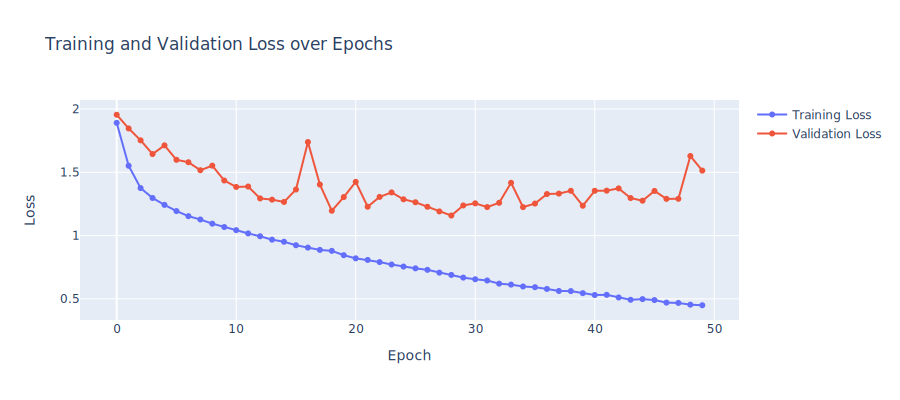

In [23]:
import plotly.graph_objects as graph
pio.renderers

fig = graph.Figure()

# the training loss 
fig.add_trace(graph.Scatter(y=train_losses, mode='lines+markers', name='Training Loss'))
# the validation loss 
fig.add_trace(graph.Scatter(y=val_losses, mode='lines+markers', name='Validation Loss'))
# Update the layout with titles and axis labels
fig.update_layout(title='Training and Validation Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  width=900,
                  height=400)

# fig.add_trace(go.Scatter(y=train_losses, fill='tozeroy', mode='lines', name='Training Loss'))  # Fill to x-axis
# fig.add_trace(go.Scatter(y=val_losses, fill='tozeroy', mode='lines', name='Validation Loss'))

fig.show(renderer="svg")

### check the accuracy of the model on the training and validation set:

In [24]:
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = 0
    total_samples = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # No track gradients
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_pred = torch.argmax(outputs, dim=1)               # Use argmax to get predictions: highest prob

            # accuracy metric as the number of correctly predicted results / total numbe of samples
            predictions += torch.sum(y_pred == labels).item()
            total_samples += labels.size(0)                        # length of tensor at first dimension

            # store for confusion matrix from scikit-learn in numpy form
            pred_labels.extend(y_pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    total_acc = predictions / total_samples
    # print(f'Accuracy: {total_acc:.2f}')
    
    return total_acc, true_labels, pred_labels

- prediction is pass the input data through the model
- true label is provide in DataLoader

In [25]:
train_accuracy, true_labels, pred_labels = calculate_accuracy(model, train_loader)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.58


In [26]:
val_accuracy, true_labels, pred_labels = calculate_accuracy(model, val_loader)
print(f'Validation Accuracy: {val_accuracy:.2f}')

Validation Accuracy: 0.47


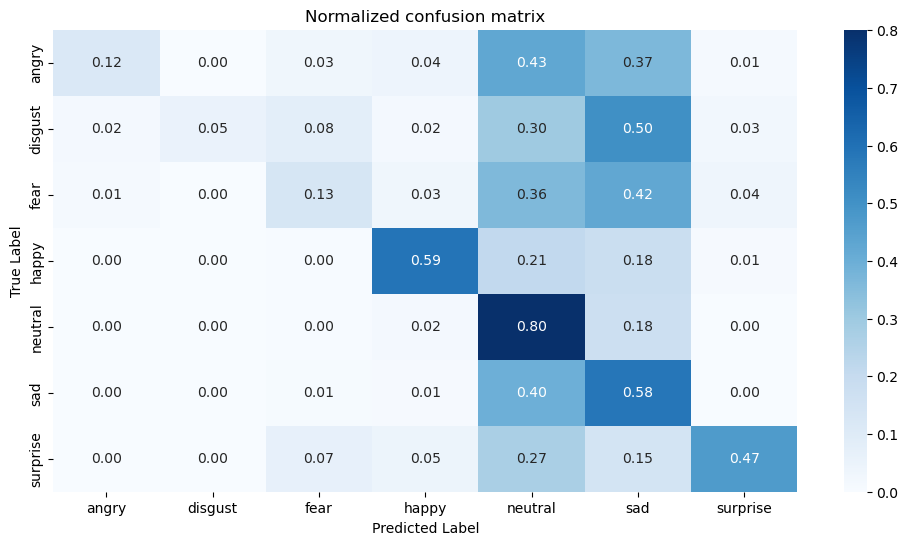

In [27]:
from sklearn.metrics import confusion_matrix

class_names = train_label.classes_

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with class names
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", fmt=".2f", cbar=True, 
            xticklabels=class_names, yticklabels=class_names)

plt.title("Normalized confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()